In [1]:

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import matplotlib as plt
import seaborn as sns
from random import randint, choice
from numpy import where
from os import path, getcwd
from main_data import (
    key_to_camelot,
    add_features,
    get_playlist,
    get_friendly,
    json_to_df,
    df_to_json,
    add_features,
    sp,
    get_pods,
)


In [2]:
# Import DataFrames generated by main_data.py
def import_all():
    (
        all_streams,
        music_streams_no_features,
        music_streams,
        playlist_example,
        podcasts,
        wheel_df,
    ) = json_to_df(
        "all_streams.json",
        "music_streams_no_features.json",
        "music_streams.json",
        "playlist_example.json",
        "podcasts.json",
        "wheel_df.json",
    )
    return (
        all_streams.assign(timestamp=all_streams.timestamp.dt.tz_convert('EST')),
        music_streams_no_features.assign(timestamp=music_streams_no_features.timestamp.dt.tz_convert('EST')),
        music_streams.assign(timestamp=music_streams.timestamp.dt.tz_convert('EST')),
        playlist_example,
        podcasts.assign(timestamp=podcasts.timestamp.dt.tz_convert('EST')),
        wheel_df,
    )


# todo: move to main


def hpm(df, average=None):
    # df["month"] = df.copy().timestamp.dt.month
    df_groupby = (
        df.sort_values(by="month")
        .groupby(["month", pd.Grouper(key="timestamp", freq="Y")])["playtime_h"]
        .sum()
        .groupby("month")
    )
    return df_groupby.mean().sort_index() if average else df_groupby.sum().sort_index()


def plothpm(df_gb):
    df_gb.index = pd.PeriodIndex(df_gb.index, freq="M")
    df_gb = df_gb.sort_index()
    df_gb.index = df_gb.index.strftime("%b")
    # df_gb.index = df_gb.rename(lambda x: x.strftime("%b"))
    return sns.barplot(data=df_gb.iloc[0:0], x=df_gb.index, y=df_gb.values)


def del_skips(deef):
    return deef.query("(playtime_s / duration) > 0.75").reset_index()


def most_played(
    df, years=False, noskips=False, artists=False, album=False, nofeatures=False
):
    # Todo: test against duration
    # Todo: do not allow conflicting params
    # Todo: consider a temporal indexing class
    cols = ["artist", "track", "year"]
    if noskips:
        df = del_skips(df)
    if not years:
        years = df.timestamp.dt.year.unique()
        cols.remove("year")
    if artists:
        cols.remove("track")
    if album:
        cols.remove("track")
        cols.append("album")
    return (
        pd.DataFrame(
            df.query("timestamp.dt.year in @years")
            .pivot_table(columns=cols, aggfunc="size")
            .sort_values(ascending=False)
        )
        .reset_index()
        .rename(columns={0: "count"})
    )


def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)


def randyear(df):
    return choice(range(df.timestamp.dt.year.min(), df.timestamp.dt.year.max() + 1))


In [7]:
# (
#     all_streams, music_streams_no_features,
#     music_streams,
#     playlist_example,
#     podcasts,
#     wheel_df,
# ) = import_all()

all_streams = pd.read_pickle("all_streams.p")
music_streams_no_features = pd.read_pickle("mus-no-feat.p")
music_streams = pd.read_pickle("music_streams.p")
playlist_example = pd.read_pickle("playlist.p")
podcasts = pd.read_pickle("pods.p")
wheel_df = pd.read_pickle("wheel.p")


#todo probably delete this
# dataframes_tz = (
#     all_streams, music_streams_no_features,
#     music_streams,
#     _df,
#     podcasts
# )
# dataframes_tz = [df.assign(timestamp=df.timestamp.dt.tz_convert('EST')) for df in dataframes_tz]
# dataframes_tz[0].timestamp.dt.tz

PermissionError: [Errno 13] Permission denied: 'music_streams.p'

In [4]:
# To start, I'd like to know how many individual songs I've listened to since July 2019.
len(music_streams["track"].unique())


NameError: name 'music_streams' is not defined

But how many did I actually listen to?

In [ ]:
len(del_skips(music_streams)["track"].unique())


I listen to a lot of music, but I was expecting less.

In [ ]:
most_played(podcasts.query("playtime_m > 3"), artists=True, nofeatures=True).head(30).sort_values(by="count", ascending=False)

<AxesSubplot:xlabel='month'>

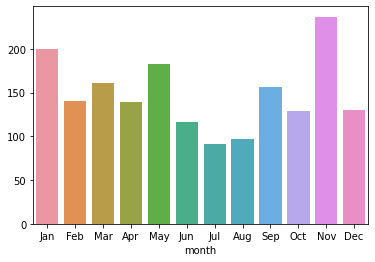

In [5]:
# Mean number of hours listened by month. With my dataset, a raw sum per month would be undesirable, as it spans partial years at the beginning and end.
plothpm(hpm(all_streams, average=True))


In [6]:
# What hours do I spend the most time streaming? Podcasts omitted due to my tendency to use them to fall asleep.
all_streams.loc[:, ["playtime_h", "timestamp"]].groupby(
    by=all_streams.timestamp.dt.hour
).sum(numeric_only=True).sort_values(by="playtime_h", ascending=False)


,playtime_h
timestamp,
10,312.55
7,306.75
6,297.87
9,297.87
5,297.37
11,297.25
8,275.74
2,263.66
4,262.18


In [ ]:
# Most played songs 2022
most_played(music_streams, noskips=True, years=[2022])


In [ ]:
# Top 30 most played tracks over the entire dataset
most_played(music_streams).head(30)


In [ ]:
# Most listened to artists by number of songs played
artists_playtime = most_played(music_streams, artists=True, noskips=True)
artists_playtime


In [ ]:
# Total time spent listening to specific albums
pd.pivot_table(
    del_skips(music_streams), values="playtime_h", index=["album"], aggfunc="sum"
).sort_values(by="playtime_h", ascending=False).head(30)


In [ ]:
# Total amount of songs listened to from individual albums
most_played(music_streams, noskips=True, album=True).head(30)


In [ ]:
# Artists I have played the most songs by
most_played(music_streams, artists=True)


In [ ]:
# Artists I have spent the most aggregate time listening to
repeated_artists = (
    pd.pivot_table(
        del_skips(music_streams), values="playtime_h", index=["artist"], aggfunc="sum"
    )
    .sort_values(by="playtime_h", ascending=False)
    .reset_index()[:1750]
)
repeated_artists.head(30)


Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should seek more songs from, and/or artists with very long average song lengths.


In [ ]:
# Count number of unique tracks per artist and create ascending list
unique_songs = (
    del_skips(music_streams)
    .query("artist in @repeated_artists['artist']", engine="python")
    .groupby("artist")
    .apply(lambda x: x["track"].unique())
    .reset_index(name="unique_titles")[:1750]
)


In [ ]:
# Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should seek more songs from, and/or artists with very long average song lengths.
unique_songs["unique_count"] = unique_songs.iloc[:, 1].str.len()
unique_songs = (
    unique_songs.sort_values(by="unique_count")
    .reset_index()
    .query("unique_count <= 8")["artist"]
)
repeated_artists.query("playtime_h > 1").query("artist in @unique_songs")


Total playtime per month:

In [ ]:
plt.rcParams["figure.figsize"] = (8, 8)
sns_prep = music_streams
sns_prep = pd.pivot_table(
    sns_prep,
    values="playtime_h",
    index=sns_prep.timestamp.dt.strftime("%b"),
    aggfunc="sum",
).reset_index()
sns.barplot(data=sns_prep, x=sns_prep.index, y="playtime_h")


Next, total skips per month. Timestamp is the best way currently implemented to pick out an individual "play" of a track or podcast.

In [ ]:
diff = music_streams["timestamp"][
    ~music_streams["timestamp"].isin(del_skips(music_streams)["timestamp"])
]
sns_prep = music_streams.query("timestamp in @diff")
sns_prep["count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "playtime_h", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")  # Todo: use plothpm() for this


In [ ]:
# common keys of listened tracks
del_skips(music_streams).loc[:, "timestamp"] = del_skips(music_streams).loc[
    :, "timestamp"
]
pivot_track = pd.DataFrame(
    del_skips(music_streams)
    .drop_duplicates(subset="timestamp")
    .pivot_table(columns=["key_signature"], aggfunc="size")
    .sort_values(ascending=False)
)
pivot_track


This function shows every track with harmonically compatible key signatures to the track matching the passed URI. Documentation to follow in further updates.

In [ ]:
get_friendly(
    music_streams, tempo_range=10, uri="5jh3f8fy8a335XYDyJ7x9R", shifts=["all"]
).sort_values(by="track")


In the next cell, I query for days where I played songs with "birthday" in the name. It turns out I definitely mostly play songs with "birthday" in the title on or around the birthdays of my friends and family members.

In [ ]:
music_streams.query("(playtime_s / duration) > 0.1").query(
    "track.str.contains('(?i)birthday')"
).sort_values(by=["month", "date"])


In [ ]:
# Total hours per month spent listening to podcasts over the entire dataset.
plothpm(hpm(podcasts))


In [ ]:
# Total hours per month spent listening to both podcasts and music over the entire period.

plothpm(hpm(all_streams))


In [ ]:
# Get total hours streamed pwr month of a year by artist
# todo: conaider adding year modifier for hpm or using classes
hpm(music_streams.loc[music_streams.year == 2019].loc[music_streams.artist == "Teebs"])

In [ ]:
# hpm(all_streams)
hue_pod = podcasts.copy()
hue_mus = music_streams.copy()
hue_pod.loc[:, "ds"] = "pods"
hue_mus.loc[:, "ds"] = "songs"
combined = pd.concat([hue_pod, hue_mus])
combined

In [ ]:
comp_df = pd.DataFrame(combined.loc[combined.year > 0].groupby(["month", "year", "ds"], as_index=True)["playtime_h"].sum()).reset_index()
#comp_df = pd.DataFrame(combined.groupby(["month", "year", "ds"], as_index=True)["playtime_h"].sum().reset_index()

comp_df.index = pd.PeriodIndex(comp_df.month, freq="M")
comp_df = comp_df.sort_index()
comp_df.index = comp_df.index.strftime("%b")

In [ ]:
def comp_hpm(df, average=None):
    # df["month"] = df.copy().timestamp.dt.month
    df_groupby = (
        df.sort_values(by="month")
        .groupby(["month", pd.Grouper(key="timestamp", freq="Y"), "ds"])["playtime_h"]
        .sum()
        .groupby(["month", "ds"])
    )
    return pd.DataFrame(df_groupby.mean()).reset_index() if average else pd.DataFrame(df_groupby.sum()).reset_index()

def comp_plothpm(df_gb):
    df_gb.index = pd.PeriodIndex(df_gb.month, freq="M")
    df_gb = df_gb.sort_index()
    df_gb.index = df_gb.index.strftime("%b")
    return sns.barplot(
        data=df_gb.reset_index(drop=True),
            x="month", y="playtime_h", hue="ds")

#Todo: turn comp into an option

In [ ]:
comp_plothpm(comp_hpm(combined, average=True))

In [ ]:
comp_plothpm(comp_hpm(combined))

In [ ]:
#music_streams.iloc

def prepare_comparison(*dfs, col_names=None):
    for i, df in enumerate(dfs):
        df = df.copy(deep=True)
        if not col_names:
            df.loc[:, "ds"] = "ds" + str(i)
        else:
            df.loc[:, "ds"] = col_names[i]
    return pd.concat([df.copy() for df in dfs])
            
prepare_comparison(podcasts, music_streams)

In [ ]:
all_streams

In [ ]:


# df.loc[df.spotify_episode_uri == None].loc[:, 'media_category'] = 'music'


In [ ]:
all_streams

In [ ]:
    
# night_streams = music_streams[~music_streams.timestamp.dt.hour.between(6,18)]
# night_streams.loc[:, "ds"] = "night"

# day_streams = music_streams[music_streams.timestamp.dt.hour.between(6,21)]
# day_streams.loc[:, "ds"] = "day"

# streams_tod = pd.concat([day_streams, night_streams])
#where(music_streams.timestamp.dt.hour.astype(int)  > 21)where(music_streams.timestamp.dt.hour.astype(int) < 6)[0]

In [ ]:
comp_plothpm(comp_hpm(streams_tod))
